# Script to predict glacier-wide mass balance from ML model

In [55]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
from pyproj import Proj, transform

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

## Classes

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [2]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
            
    # Initialize gradients and hessians
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred)

    # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
    # based on the metadata.
    #y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)
    df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

    # Aggregate y_pred and y_true for each group
    grouped_ids = df_metadata.assign(y_true=y_true, y_pred=y_pred).groupby('ID')
    y_pred_agg = grouped_ids['y_pred'].sum().values
    y_true_mean = grouped_ids['y_true'].mean().values
    
    # Compute gradients
    gradients_agg = y_pred_agg - y_true_mean

    # Create a mapping from ID to gradient
    gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

    # Assign gradients to corresponding indices
    df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
    gradients[df_metadata.index] = df_metadata['gradient'].values

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [3]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

        # Aggregate y_pred and y_true for each group
        grouped_ids = df_metadata.assign(y_true=y, y_pred=y_pred).groupby('ID')
        y_pred_agg = grouped_ids['y_pred'].sum().values
        y_true_mean = grouped_ids['y_true'].mean().values

        # Compute mse 
        mse = ((y_pred_agg - y_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score          


## Helper functions

In [4]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [5]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [6]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [7]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

## Prepare topographical features for glacier

In [65]:
filepath_topo = 'Data/oggm_data/per_glacier/RGI60-08/RGI60-08.01/RGI60-08.01126/'
filename_grid = 'gridded_data.nc'
glacier_id = 2297

In [59]:
with xr.open_dataset(filepath_topo + filename_grid) as ds_out:
    ds = ds_out

In [15]:
ds

<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables: (12/20)
    topo                     (y, x) float32 ...
    topo_smoothed            (y, x) float32 ...
    topo_valid_mask          (y, x) int8 ...
    glacier_mask             (y, x) int8 ...
    glacier_ext              (y, x) int8 ...
    consensus_ice_thickness  (y, x) float32 ...
    ...                       ...
    aspect                   (y, x) float32 ...
    slope_factor             (y, x) float32 ...
    dis_from_border          (y, x) float32 ...
    catchment_area           (y, x) float32 ...
    lin_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z          (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

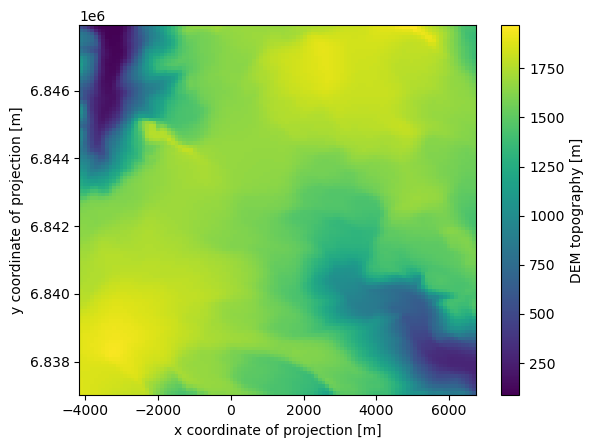

In [17]:
ds.topo.plot()

In [53]:
# Get glacier mask (ones) as numpy array
#mask = ds.glacier_mask.values

# Get glacier elevation as numpy array
#elev = ds.topo.values 

# Get array of elevation in glacier grid cells
#masked_elev = elev * mask

# Get vector of elevation in glacier grid cells
#masked_elev_vec = masked_elev[masked_elev>0]

In [62]:
# Assuming ds is your xarray dataset and 'glacier_mask' and 'topo' are the variable names
glacier_mask = ds['glacier_mask'].values  # Retrieve the glacier mask as a numpy array
elev = ds['topo'].values  # Retrieve the elevation data as a numpy array
slope = ds['slope'].values
aspect = ds['aspect'].values

# Ensure the mask is interpreted correctly as a boolean array
glacier_mask_bool = glacier_mask == 1

# Apply the mask to retrieve only elevation values of glacier cells
masked_elev = elev[glacier_mask_bool]
masked_slope = slope[glacier_mask_bool]
masked_aspect = aspect[glacier_mask_bool]

# Get the indices where the glacier mask is True (indicating glacier cells)
glacier_indices = np.where(glacier_mask_bool)

# Assuming the coordinate variables are named 'x' and 'y' in your dataset
x_coords = ds['x'].values
y_coords = ds['y'].values

# Retrieve the x and y values using the glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]

# Print the resulting vectors
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)
print("Glacier elevations:", masked_elev)
print("Glacier slope:", masked_slope)
print("Glacier aspect:", masked_aspect)


Glacier x-coordinates: [2649.8687 2649.8687 2750.8687 ... 3457.8687 5578.8687 5679.8687]
Glacier y-coordinates: [6846870. 6846769. 6846769. ... 6838083. 6838083. 6838083.]
Glacier elevations: [1892.9403  1892.8458  1887.9578  ... 1382.6019   325.31317  311.37354]
Glacier slope: [0.01796639 0.01447995 0.05263601 ... 0.47875875 0.29218474 0.17109412]
Glacier aspect: [1.9658048 2.312331  1.6276278 ... 0.8793251 1.0466181 1.1233389]


In [63]:
# Define the source projection from the dataset's coordinate system
proj_string = ds.pyproj_srs
source_proj = Proj(proj_string)

# Define the target projection (WGS84)
target_proj = Proj(proj='latlong', datum='WGS84')

# Convert glacier coordinates to latitude and longitude
lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)

# Print or return the resulting latitude and longitude vectors
print("Latitude coordinates:", latitude)
print("Longitude coordinates:", longitude)

Latitude coordinates: [61.75483469 61.75392802 61.75392731 ... 61.67594778 61.67592281
 61.67592133]
Longitude coordinates: [7.14918911 7.14918764 7.15110054 ... 7.16432571 7.20439537 7.20630344]


C:\Users\kasj\AppData\Local\Temp\ipykernel_13924\306259850.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)


In [80]:
# Create a DataFrame
data = {
    'RGIID': ['RGI60-08.01126'] * len(masked_elev_vec),
    'BREID': [2297] * len(masked_elev_vec),
    'altitude': masked_elev,
    'lat': latitude,
    'lon': longitude,
    'aspect': masked_aspect,
    'slope': masked_slope
}

df = pd.DataFrame(data, columns=['RGIID', 'BREID', 'altitude', 'lat', 'lon', 'aspect', 'slope'])


In [81]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope
0,RGI60-08.01126,2297,1892.940308,61.754835,7.149189,1.965805,0.017966
1,RGI60-08.01126,2297,1892.845825,61.753928,7.149188,2.312331,0.014480
2,RGI60-08.01126,2297,1887.957764,61.753927,7.151101,1.627628,0.052636
3,RGI60-08.01126,2297,1879.727173,61.753927,7.153013,1.562562,0.077785
4,RGI60-08.01126,2297,1891.655151,61.753021,7.149186,2.888830,0.017641
...,...,...,...,...,...,...,...
4095,RGI60-08.01126,2297,1481.832031,61.675950,7.160510,1.024609,0.428113
4096,RGI60-08.01126,2297,1426.396362,61.675949,7.162418,0.960831,0.476907
4097,RGI60-08.01126,2297,1382.601929,61.675948,7.164326,0.879325,0.478759
4098,RGI60-08.01126,2297,325.313171,61.675923,7.204395,1.046618,0.292185


In [82]:
# Add years
years = np.arange(1960, 2022)
num_years = len(years)
num_rows_per_year = len(df)

# Repeat the DataFrame num_years times
df = pd.concat([df] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)

# Add the 'year' column to the DataFrame
df['year'] = year_column

In [83]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope,year
0,RGI60-08.01126,2297,1892.940308,61.754835,7.149189,1.965805,0.017966,1960
1,RGI60-08.01126,2297,1892.845825,61.753928,7.149188,2.312331,0.014480,1960
2,RGI60-08.01126,2297,1887.957764,61.753927,7.151101,1.627628,0.052636,1960
3,RGI60-08.01126,2297,1879.727173,61.753927,7.153013,1.562562,0.077785,1960
4,RGI60-08.01126,2297,1891.655151,61.753021,7.149186,2.888830,0.017641,1960
...,...,...,...,...,...,...,...,...
254195,RGI60-08.01126,2297,1481.832031,61.675950,7.160510,1.024609,0.428113,2021
254196,RGI60-08.01126,2297,1426.396362,61.675949,7.162418,0.960831,0.476907,2021
254197,RGI60-08.01126,2297,1382.601929,61.675948,7.164326,0.879325,0.478759,2021
254198,RGI60-08.01126,2297,325.313171,61.675923,7.204395,1.046618,0.292185,2021


## Add climate features for glacier

In [84]:
filepath_climate = 'Data/ERA5-Land_mon_avg_1950_2022_Norway/'
filename_climate = 'data.nc'

In [85]:
# Load climate cataset
with xr.open_dataset(filepath_climate + filename_climate) as ds:
    ds_climate = ds.load()

# Reduce expver dimension
ds_climate = ds_climate.reduce(np.nansum, 'expver')

In [89]:
# ds_climate contains 14 variables:
# ['u10','v10','t2m','fal','asn','sde','sd','slhf','ssr','str','sshf','ssrd','strd','tp']
# u10: 10m u-component of wind, 
# v10: 10m v-component of wind, 
# t2m: 2m temperature, 
# fal: Forecast albedo, 
# asn: Snow albedo, 
# sde: Snow depth, 
# sd: Snow depth water equivalent, 
# slhf: Surface latent heat
# ssr: Surface net solar radiation, 
# str: Surface net thermal radiation,
# sshf: Surface sensible heat flux, 
# ssrd: Surface solar radiation downwards, 
# strd: Surface thermal radiation downwards, 
# tp: Total precipitation

ds_climate

<xarray.Dataset>
Dimensions:    (longitude: 271, latitude: 141, time: 880)
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 30.7 30.8 30.9 31.0
  * latitude   (latitude) float32 71.5 71.4 71.3 71.2 ... 57.8 57.7 57.6 57.5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-04-01
Data variables: (12/14)
    u10        (time, latitude, longitude) float32 0.0 0.0 ... -0.6157 -0.6011
    v10        (time, latitude, longitude) float32 0.0 0.0 ... -0.3065 -0.2986
    t2m        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 280.4 280.5
    fal        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.2273 0.2009
    asn        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.644 0.6407
    sde        (time, latitude, longitude) float32 0.0 0.0 ... 0.06174 0.05579
    ...         ...
    ssr        (time, latitude, longitude) float32 0.0 0.0 ... 7.523e+06
    str        (time, latitude, longitude) float32 0.0 0.0 ... -2.835e+06
    sshf       (time, latitude, longitude) float32 0.0 0.0 ... -1.193e+06
    ssrd       (time, latitude, longitude) float32 0.0 0.0 ... 9.21e+06
    strd       (time, latitude, longitude) float32 0.0 0.0 ... 1.277e+07
    tp         (time, latitude, longitude) float32 0.0 0.0 ... 0.0003496

In [87]:
# Get latitude and longitude of Norway climate data
lat_clim = ds_climate.latitude
lon_clim = ds_climate.longitude
    
#%% Load geopotential height
with xr.open_dataset(filepath_climate + 'geo.nc') as ds_geo:
    ds_geopotential = ds_geo.load()
    
# Convert geopotential height to geometric height and add to dataset
R_earth = 6367.47 * 10e3 #m (Grib1 radius)
g = 9.81 # m/s2

ds_geopot_metric = ds_geopotential.assign(altitude_climate = lambda ds_geopotential: 
                                          R_earth * ((ds_geopotential.z/g)/(R_earth - (ds_geopotential.z/g))))

# Crop geometric height to grid of climate data
ds_geopot_metric_crop = ds_geopot_metric.sel(longitude = lon_clim, latitude = lat_clim)

In [92]:
# Selection of climate variables
#var_names = list(ds_climate.keys())
var_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
month_names = ['_oct','_nov','_dec','_jan','_feb','_mar','_apr','_may','_jun','_jul','_aug','_sep']

# Combine variables and months
month_vars = []
for var in var_names:
    month_vars.extend([f'{var}{mm:02}' for mm in month_names])

In [102]:
# Empty array to store values.
climate_all = np.empty((len(df.index),len(month_vars)))
climate_all.fill(np.nan)

altitude_all = np.empty((len(df.index),1))
altitude_all.fill(np.nan)


In [104]:
# Get data for each point in dataframe

total_iterations = len(df)

for i in df.index:
    
    # Get location and year for point measurement
    lat_stake = df.loc[i,'lat'].round(2)#.values.round(2)
    lon_stake = df.loc[i,'lon'].round(2)#.values.round(2)
    #date_stake = pd.to_datetime(point_data.loc[i,'dt_curr_year_max_date'], format="%d.%m.%Y %H:%M")
    year_stake = df.loc[i,'year']
    
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                               longitude=lon_stake,
                               time=pd.date_range(str(year_stake-1) + '-09-01',
                                                  str(year_stake) + '-09-01',
                                                  freq='M'),
                               method = "nearest")
    
    # Convert dataarray to dataframe.
    d_climate = p_climate.to_dataframe()
    
    # Drop latitude and longitude columns from dataframe.
    d_climate.drop(columns=['latitude','longitude'],inplace=True)
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method = "nearest")
    
    #d_climate['altitude_climate'] = p_alt.altitude_climate.values[0]
    
    # Flatten dataframe along columns such that each column (oct-sept)
    # follows each other in the flattened array
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Store in array.
    climate_all[i,:] = a_climate
    altitude_all[i,:] = p_alt.altitude_climate.values[0]

    # Print progress every 5000 iterations
    if i % 5000 == 0:
        print(f'Iteration {i} of {total_iterations}')


Iteration 0 of 254200
Iteration 5000 of 254200
Iteration 10000 of 254200
Iteration 15000 of 254200
Iteration 20000 of 254200
Iteration 25000 of 254200
Iteration 30000 of 254200
Iteration 35000 of 254200
Iteration 40000 of 254200
Iteration 45000 of 254200
Iteration 50000 of 254200
Iteration 55000 of 254200
Iteration 60000 of 254200
Iteration 65000 of 254200
Iteration 70000 of 254200
Iteration 75000 of 254200
Iteration 80000 of 254200
Iteration 85000 of 254200
Iteration 90000 of 254200
Iteration 95000 of 254200
Iteration 100000 of 254200
Iteration 105000 of 254200
Iteration 110000 of 254200
Iteration 115000 of 254200
Iteration 120000 of 254200
Iteration 125000 of 254200
Iteration 130000 of 254200
Iteration 135000 of 254200
Iteration 140000 of 254200
Iteration 145000 of 254200
Iteration 150000 of 254200
Iteration 155000 of 254200
Iteration 160000 of 254200
Iteration 165000 of 254200
Iteration 170000 of 254200
Iteration 175000 of 254200
Iteration 180000 of 254200
Iteration 185000 of 254200

In [ ]:
# Efficient version?

from joblib import Parallel, delayed

# Assuming ds_climate and ds_geopot_metric_crop are xarray Datasets
# Predefine the time selection range once
years_unique = df['year'].unique()
time_selector = {
    year: pd.date_range(start=f"{year-1}-09-01", end=f"{year}-09-01", freq='M')
    for year in years_unique
}

# Convert latitude and longitude to pandas index
lat_stake_arr = df['lat'].round(2).to_numpy()
lon_stake_arr = df['lon'].round(2).to_numpy()
year_stake_arr = df['year'].to_numpy()

# Resultant arrays
climate_all = np.zeros((len(df), len(var_names) * 12))
altitude_all = np.zeros((len(df), 1))

def process_point(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector):
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                                          longitude=lon_stake,
                                          time=time_selector[year_stake],
                                          method="nearest")
    
    # Convert DataArray to DataFrame, removing latitude/longitude
    d_climate = p_climate.to_dataframe().reset_index(drop=True).drop(['latitude', 'longitude'], axis=1, errors='ignore')
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method="nearest").values
    altitude = p_alt[0] if p_alt.size > 0 else np.nan
    
    # Return as tuple
    return index, a_climate, altitude

# Process points in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_point)(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector)
    for index, lat_stake, lon_stake, year_stake in zip(df.index, lat_stake_arr, lon_stake_arr, year_stake_arr)
)

# Update results into the arrays
for index, a_climate, altitude in results:
    climate_all[index, :] = a_climate
    altitude_all[index, 0] = altitude

print("Processing completed")


In [106]:
# Make pandas dataframe from array with column names from month_vars
df_climate = pd.DataFrame(data = climate_all, columns = month_vars)
df_altitude = pd.DataFrame(data = altitude_all, columns = ['altitude_climate'])



In [109]:
# Concatenate dataframes
df_w_climate = pd.concat([df, df_climate, df_altitude], axis=1)#.reindex(point_data.index)

In [111]:
# Save dataframe
filepath_save = 'Data/'
filename_save = 'nigardsbreen_latlon_wattributes_climate.csv'
df_w_climate.to_parquet(filepath_save + filename_save)

In [112]:
# Save dataframe
filepath_save = 'Data/'
filename_save = 'nigardsbreen_latlon_wattributes_climate.csv'
df_w_climate.to_csv(filepath_save + filename_save, index=False) 

## Load ML-model

In [8]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_


## Load dataframe

In [114]:
# Load dataframe
filepath_glacier_data = 'Data/'
filename_glacier_data = 'nigardsbreen_latlon_wattributes_climate.csv'
df_glacier = pd.read_csv(filepath_glacier_data + filename_glacier_data)#, sep=';')\n",

# Set prediction specifications
pred_type = 'winter'
pred_range = np.arange(1960, 1965)


In [115]:
df_glacier

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.01126,2297,1892.94030,61.754835,7.149189,1.965805,0.017966,1960,272.877167,267.935944,...,0.002399,0.001828,0.000776,0.004557,0.00170,0.005879,0.004989,0.004205,0.003978,1238.953059
1,RGI60-08.01126,2297,1892.84580,61.753928,7.149188,2.312331,0.014480,1960,272.877167,267.935944,...,0.002399,0.001828,0.000776,0.004557,0.00170,0.005879,0.004989,0.004205,0.003978,1238.953059
2,RGI60-08.01126,2297,1887.95780,61.753927,7.151101,1.627628,0.052636,1960,272.877167,267.935944,...,0.002399,0.001828,0.000776,0.004557,0.00170,0.005879,0.004989,0.004205,0.003978,1238.953059
3,RGI60-08.01126,2297,1879.72720,61.753927,7.153013,1.562562,0.077785,1960,272.877167,267.935944,...,0.002399,0.001828,0.000776,0.004557,0.00170,0.005879,0.004989,0.004205,0.003978,1238.953059
4,RGI60-08.01126,2297,1891.65520,61.753021,7.149186,2.888830,0.017641,1960,272.877167,267.935944,...,0.002399,0.001828,0.000776,0.004557,0.00170,0.005879,0.004989,0.004205,0.003978,1238.953059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254195,RGI60-08.01126,2297,1481.83200,61.675950,7.160510,1.024609,0.428113,2021,272.168152,269.930206,...,0.002267,0.004056,0.005701,0.003865,0.00157,0.004419,0.003304,0.003071,0.004910,1322.716089
254196,RGI60-08.01126,2297,1426.39640,61.675949,7.162418,0.960831,0.476907,2021,272.168152,269.930206,...,0.002267,0.004056,0.005701,0.003865,0.00157,0.004419,0.003304,0.003071,0.004910,1322.716089
254197,RGI60-08.01126,2297,1382.60190,61.675948,7.164326,0.879325,0.478759,2021,272.168152,269.930206,...,0.002267,0.004056,0.005701,0.003865,0.00157,0.004419,0.003304,0.003071,0.004910,1322.716089
254198,RGI60-08.01126,2297,325.31317,61.675923,7.204395,1.046618,0.292185,2021,272.168152,269.930206,...,0.002267,0.004056,0.005701,0.003865,0.00157,0.004419,0.003304,0.003071,0.004910,1322.716089


In [ ]:
# Crop dataframe to prediction range
df_glacier_crop = 

# Add column with n_months
if pred_type == 'winter':
    df_glacier['n_months'] = 7
elif pred_type == 'summer':
    df_glacier['n_months'] = 5
elif pred_type == 'annual':
    df_glacier['n_months'] = 12


In [ ]:
# prepare dataframe, e.g. add altitude_diff

In [ ]:
# melt dataframe to give monthly values

In [ ]:
# For each year:

    # get X_test numpy array
    # predict on X_test
    # sum X_test

